In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
def load_data(file_path):
    all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]
    df_list = []

    for file in all_files:
        df = pd.read_csv(file, encoding='latin1')
        df.columns = df.columns.str.strip()
        df_list.append(df)
    
    return df_list


def preprocess_data(df_list):
    full_df = pd.concat(df_list, ignore_index=True)
    
    # 무한대 값을 NaN으로 바꾸고, NaN 값을 포함하는 행 제거
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_df.dropna(inplace=True)
    
    # 숫자형이 아닌 열과 레이블 열 제외
    numeric_cols = full_df.select_dtypes(include=np.number).columns.tolist()
    
    # 정상 데이터만 선택
    benign_df = full_df[full_df['Label'] == 'BENIGN']
    attack_df = full_df[full_df['Label'] != 'BENIGN']
    
    # 스케일링
    scaler = MinMaxScaler()
    benign_scaled = scaler.fit_transform(benign_df[numeric_cols])
    attack_scaled = scaler.transform(attack_df[numeric_cols])
    
    return benign_scaled, attack_scaled, benign_df, attack_df, numeric_cols, scaler

data_path = 'dataset/'
df_list = load_data(data_path)
benign_data, attack_data = preprocess_data(df_list)

C:\Users\jalna\AppData\Local\Temp\ipykernel_24388\216364003.py:5: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')


In [5]:
## Autoencoder
input_dim = benign_data.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(benign_data, benign_data)




70979/70979 [==============================] - 142s 2ms/step - loss: 3.8417e-04


In [ ]:
benign_pred = autoencoder.predict(benign_data)
attack_pred = autoencoder.predict(attack_data)

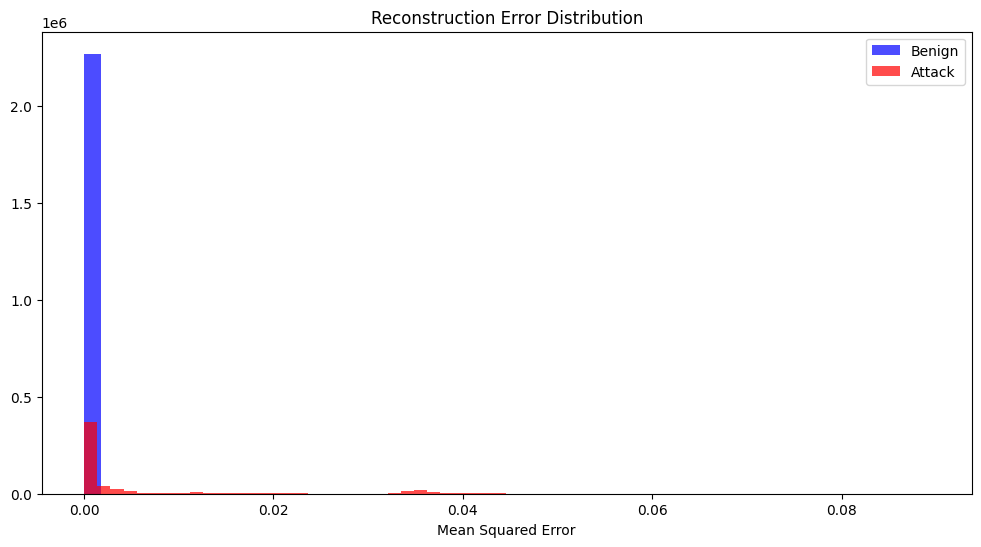

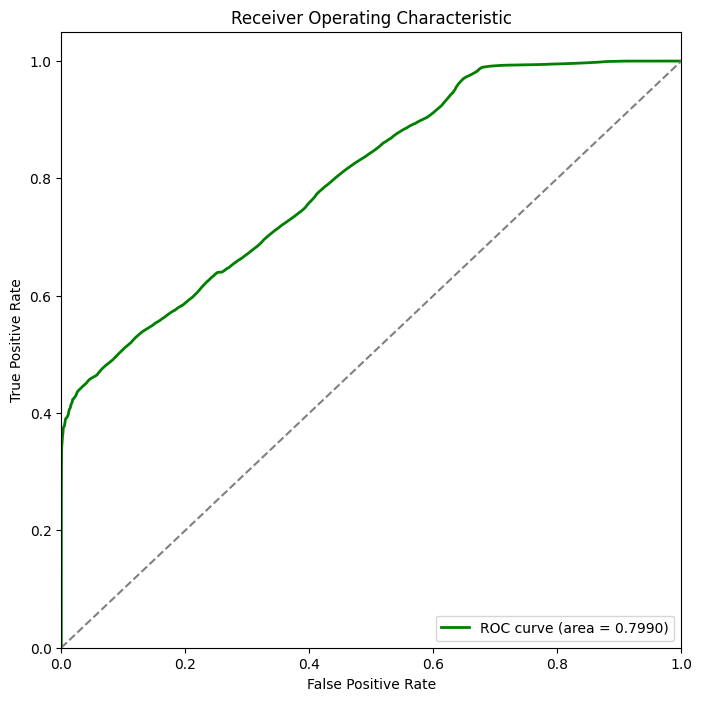

In [ ]:
## Reconstruction Error
benign_mse = np.mean(np.power(benign_data - benign_pred, 2), axis=1)
attack_mse = np.mean(np.power(attack_data - attack_pred, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.hist(benign_mse, bins=50, color='blue', alpha=0.7, label='Benign')
plt.hist(attack_mse, bins=50, color='red', alpha=0.7, label='Attack')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

## ROC curve
true_labels = np.concatenate([np.zeros(len(benign_mse)), np.ones(len(attack_mse))])
pred_scores = np.concatenate([benign_mse, attack_mse])

fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()